In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

import warnings
warnings.simplefilter('ignore')

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

(1000,)


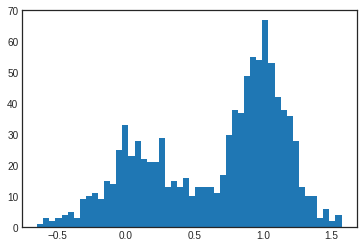

In [5]:
# Generate mixture of 1D Gaussians
components = 2
dims = 1
n_data = 1000

# centers = tfp.distributions.Normal(loc=1., scale=2.).sample(components)
# stds = tfp.distributions.Uniform(low=0.5, high=1.).sample(components)
# p1 = tfp.distributions.Uniform(low=0.2, high=0.8).sample()
# p2 = 1 - p1

centers = [0.1, 1.]
stds = [0.3, 0.2]
p1 = 0.4
p2 = 1 - p1

dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution = tfp.distributions.Categorical(probs=[p1, p2]),
    components_distribution = tfp.distributions.Normal(
        loc=centers,
        scale=stds))

with tf.Session() as sess:
    data = sess.run(dist.sample(n_data))
    
print(data.shape)
_ = plt.hist(data, bins=50)

I had many problems with the 
``` python
def model():
    ...
    
log_joint = tfp.edward2.make_log_joint_fn(model)
```
It seems like having the Categorical distribution as input to the log prob function causes errors.
Many `None` gradients encountered.
So, copy from the TFP BGMM [example](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb), without the custom MVN distribution (because I don't understand it).

In [6]:
rv_p = tfp.distributions.Dirichlet(name='p', concentration=[1./components]*components)
rv_mu = tfp.distributions.Normal(name='mu', loc=[0.]*components, scale=[1.]*components)
rv_sigma = tfp.distributions.Uniform(name='sigma', low=[0.]*components, high=[1.]*components)

def joint_log_prob(observations, p, loc, sigma):
    rv_observations = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(probs=p),
        components_distribution=tfp.distributions.Normal(
            loc=loc, scale=sigma))
    log_prob_parts = [
        rv_observations.log_prob(observations),
        rv_p.log_prob(p)[..., tf.newaxis],
        rv_mu.log_prob(loc),
        rv_sigma.log_prob(sigma)
    ]
    sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1))
    return sum_log_prob

In [7]:
posterior_log_prob = lambda *args: joint_log_prob(data, *args)

In [8]:
initial_state = [
    tfp.edward2.Dirichlet(concentration=[1./components]*components),
    tfp.edward2.Normal(loc=[0.]*components, scale=[1.]*components),
    tfp.edward2.Uniform(low=[0.]*components, high=[1.]*components)
]

In [13]:
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=15000,
    num_burnin_steps=3000,
    current_state=initial_state,
    kernel= tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.HamiltonianMonteCarlo(
        posterior_log_prob,
        step_size=0.01,
        num_leapfrog_steps=10),
    bijector=[
        tfp.bijectors.SoftmaxCentered(),
        tfp.bijectors.Identity(),    
        tfp.bijectors.Identity(),    
    ]))

[p_post, locs_post, scales_post] = states
accepted = kernel_results.inner_results.is_accepted

In [14]:
with tf.Session() as sess:
    [ p_post_, locs_post_, scales_post_, accepted_] = sess.run([
        p_post, locs_post, scales_post, accepted])
    
print('accepted:', accepted_.sum())
print('p:', np.mean(p_post_, axis=0))
print('loc:', np.mean(locs_post_, axis=0))
print('scale:', np.mean(scales_post_, axis=0))

accepted: 10895
p: [0.61589825 0.3841019 ]
loc: [0.9962097  0.10723097]
scale: [0.19532879 0.2779499 ]


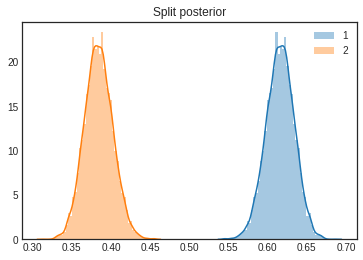

In [15]:
sns.distplot(p_post_[:,0], label='1')
sns.distplot(p_post_[:,1], label='2')
plt.title('Split posterior')
plt.legend()

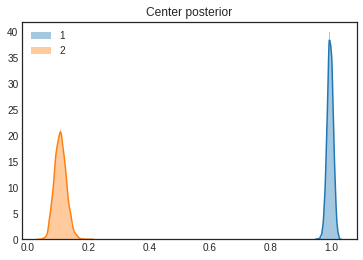

In [16]:
sns.distplot(locs_post_[:,0], label='1')
sns.distplot(locs_post_[:,1], label='2')
plt.title('Center posterior')
plt.legend()

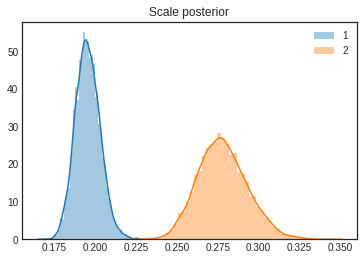

In [17]:
sns.distplot(scales_post_[:, 0], label='1')
sns.distplot(scales_post_[:, 1], label='2')
plt.title('Scale posterior')
plt.legend()

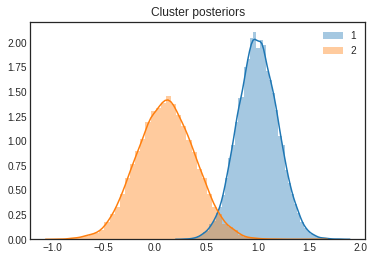

In [18]:
posterior_cluster_1 = tfp.distributions.Normal(loc=locs_post_[:,0], scale=scales_post_[:,0]).sample()
posterior_cluster_2 = tfp.distributions.Normal(loc=locs_post_[:,1], scale=scales_post_[:,1]).sample()
with tf.Session() as sess:
    post_cluster_1, post_cluster_2 = sess.run([posterior_cluster_1,posterior_cluster_2])
    
sns.distplot(post_cluster_1, label='1')
sns.distplot(post_cluster_2, label='2')
plt.title('Cluster posteriors')
plt.legend()